<a href="https://colab.research.google.com/github/dnhshl/cc-ai/blob/main/simpleRobot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# simpleRobot
Neuronales Netz zur Berechnung der inversen Kinematik eines (sehr einfachen) Roboters mit zwei Freiheitsgraden.





## Lade notwendige Libraries


In [4]:
#!pip install keras_sequential_ascii

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt

import tensorflow.keras.backend as kb

#from keras_sequential_ascii import keras2ascii



# Daten

Generiere Trainingsdaten. Das ist hier sehr einfach, da bei bekannten Winkeln `phi1` und `phi2` die `x` und `y` Position berechnet werden kann. 

Der Einfachheit halber (um auszuschließen, dass gleiche Positionen mit unterschiedlichen Winkelstellungen angefahren werden können) wird `phi1` auf 0 .. 90 Grad und `phi2` auf -90 .. 0 Grad eingeschränkt.

## Vorab: Vektoren und Matrizen in numpy

In [ ]:
a = np.array([1,2,3]) # Zeilenvektor a
b = np.array([4,5,6]) # Zeilenvektor b

M = np.vstack((a, b)) # Zusammenfassen als 2x3 Matrix

M = M.T # Transponieren -> 3x2 Matrix

print(a, b)
print(M)

sum_a_b = M.sum(axis=1) # Summe der Spaltenvektoren
print(sum_a_b)

[1 2 3] [4 5 6]
[[1 4]
 [2 5]
 [3 6]]
[5 7 9]


## OK, jetzt also die Trainingsdaten

In [5]:
l1 = 0.3  # Länge des ersten Roboterarms
l2 = 0.3  # Länge des zweiten Roboterarms

traindatasize = 1000000 # Wie viele Traingsdaten sollen generiert werden?


def gen_data(size):

  # phi1 im Bereich von -90 .. 0 Grad 
  q1 = -np.random.random_sample(size) * np.pi/2

  # phi2 im Bereich von 0 .. 90 Grad 
  q2 = np.random.random_sample(size) * np.pi/2

  # Kombiniere Vektoren als Matrix
  dout = np.vstack((q1, q2)).T

  # Berechne x und y
  din = np.array([l1 * np.cos(dout[:,0]) + l2 * np.cos(dout.sum(axis=1)), 
                  l1 * np.sin(dout[:,0]) + l2 * np.sin(dout.sum(axis=1))]).T 

  _, unique = np.unique(din.round(decimals=3), return_index=True, axis=0) 
  #print(unique)

  #print(din.round(decimals=3))


  return (din[unique], dout[unique])



(din, dout) = gen_data(traindatasize)
#print(din)

print(din.shape)

somedata = np.random.choice(dout.shape[0], 5)

print(dout[somedata]*180/np.pi)
print(din[somedata])





(141712, 2)
[[-75.51202422  46.00778583]
 [-34.53319206  27.24960736]
 [-84.17994141  66.00896582]
 [-17.44298162  75.34486317]
 [-15.03990424  55.66501816]]
[[ 0.33614883 -0.43820643]
 [ 0.54471862 -0.2080992 ]
 [ 0.31546042 -0.39200968]
 [ 0.44561595  0.16421485]
 [ 0.5174194   0.11748457]]


## Welcher Bereich `(x, y)` kann vom Roboter erreicht werden?

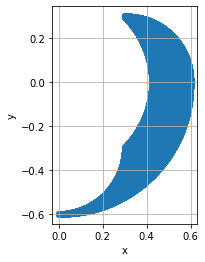

In [6]:

def plot_range():
  plt.scatter(din[:,0], din[:,1])
  plt.xlabel('x')
  plt.ylabel('y')
  #plt.xlim(0,2.5)
  plt.grid(True)
  plt.gca().set_aspect("equal")


plot_range()

# NN

Zwei Fully Connected Layer, der erste Layer mit Aktivierungsfunktion.

Als Fehlerfunktion wird der quadratische Fehler genutzt. Sie können auch [andere Loss Functions](https://keras.io/api/losses/) ausprobieren.

Testen Sie auch verschiedene [Optimizer](https://keras.io/api/optimizers/) .

## Hyperparameter

In [7]:
# Netzwerkparameter

layer1size = 30
layer2size = 20

# Trainingsparameter

myoptimizer = optimizers.Adam
learning_rate = 0.001
batch_size = 50
epochs = 10

In [64]:
def mylossfunction(expected, predicted):
  #inexp = np.array([l1 * np.cos(expected[:,0]) + l2 * np.cos(expected.sum(axis=1)), 
   #               l1 * np.sin(expected[:,0]) + l2 * np.sin(expected.sum(axis=1))]).T
  #inpred = np.array([l1 * np.cos(predicted[:,0]) + l2 * np.cos(predicted.sum(axis=1)), 
    #              l1 * np.sin(predicted[:,0]) + l2 * np.sin(predicted.sum(axis=1))]).T
  return kb.mean(kb.sum(kb.square(expected-predicted)))



def q2x(q):

    l1 = 1
    l2 = 1

    q = tf.convert_to_tensor(q)
    print(q.shape)

    x = l1*kb.cos(q[:,0]) +l2*kb.cos(tf.reduce_sum(q,1))
    y = l1*kb.sin(q[:,0]) +l2*kb.sin(tf.reduce_sum(q,1))

    tf.print('x: ', x)
    tf.print('y: ', y)
 
    return tf.stack([x,y], axis=0)


def custom_loss2(y_true,y_pred):

    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)


    x_in = l1*kb.cos(y_true[:,0]) +l2*kb.cos(tf.reduce_sum(y_true,0))
    y_in = l1*kb.sin(y_true[:,0]) +l2*kb.sin(tf.reduce_sum(y_true,0))
    coord_true = tf.convert_to_tensor([x_in, y_in])

 
    r = tf.random.uniform(shape=(), minval=1, maxval=1000, dtype=tf.int32)
    r = 5
    if r == 5: tf.print('coord_true', coord_true)

    x_out = l1*kb.cos(y_pred[:,0]) +l2*kb.cos(tf.reduce_sum(y_pred,0))
    y_out = l1*kb.sin(y_pred[:,0]) +l2*kb.sin(tf.reduce_sum(y_pred,0))
    coord_pred = tf.convert_to_tensor([x_out, y_out])


    
    if r == 5: tf.print('coord_pred', coord_pred)

    return kb.mean(kb.square(coord_true - coord_pred))


def custom_loss(y_true,y_pred):

    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)


    r = tf.random.uniform(shape=(), minval=1, maxval=2000, dtype=tf.int32)
    if r == 5: tf.print('\nytrue_true', y_true)
   
    if r == 5: tf.print('\ny_pred', y_pred)

    if r == 5: tf.print('\nreturn', kb.square(y_true - y_pred))

    return kb.mean(kb.square(y_true - y_pred))    

In [65]:
y_true = [[0, 0.], [np.pi/4, 0.]]
y_pred = [[np.pi/2, 0.], [0, 0] ]
# Using 'auto'/'sum_over_batch_size' reduction type.  
#mse = tf.keras.losses.MeanSquaredError()
#mse(y_true, y_pred).numpy()
#custom_loss2(y_true, y_pred).numpy()


q =  tf.convert_to_tensor([[np.pi, np.pi/2], [0,np.pi]])
tf.print(q)

tf.print(q[:,0])
tf.print(tf.reduce_sum(q,1))

tf.print(q2x(q))

[[3.14159274 1.57079637]
 [0 3.14159274]]
[3.14159274 0]
[4.71238899 3.14159274]
(2, 2)
x:  [-1 0]
y:  [-1.00000012 -8.74227766e-08]
[[-1 0]
 [-1.00000012 -8.74227766e-08]]


## Konstruiere NN

In [18]:
def build_and_compile_model():
  model = keras.Sequential([
      layers.Dense(layer1size, input_shape=[2,], activation='tanh', kernel_initializer='he_uniform'),
      layers.Dense(layer2size, activation='tanh',  kernel_initializer='he_uniform'),
      #layers.Dense(layer2size, activation='relu',  kernel_initializer='he_uniform'),
      layers.Dense(2, kernel_initializer='he_uniform')     ## output
  ])

  model.compile(loss=custom_loss,
                optimizer=myoptimizer(learning_rate=0.01))
  return model

In [19]:
mymodel = build_and_compile_model()
mymodel.summary()

print()
print('________________________')
print('NN Struktur in Ascii Art')
print('________________________')
print()

#keras2ascii(mymodel)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 30)                90        
_________________________________________________________________
dense_7 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 42        
Total params: 752
Trainable params: 752
Non-trainable params: 0
_________________________________________________________________

________________________
NN Struktur in Ascii Art
________________________



## Trainiere Modell

Nutze 20% der Testdaten als Validierungsdatensatz

In [20]:


history = mymodel.fit(din, dout,
          batch_size=4, epochs=1,
          validation_split = 0.2)

 6723/28343 [======>.......................] - ETA: 39s - loss: 0.0246
ytrue_true [[-1.156672 0.264125049]
 [-0.942017376 0.472767055]
 [-1.13557 1.25166798]
 [-0.231660157 0.958096683]]

y_pred [[-1.17890549 0.384334564]
 [-0.880074084 0.418080747]
 [-1.10233927 1.24233639]
 [-0.198656917 0.916369915]]

return [[0.00049432792 0.0144503275]
 [0.00383697147 0.00299059227]
 [0.00110428489 8.7078457e-05]
 [0.00108921388 0.00174112315]]
13279/28343 [=============>................] - ETA: 27s - loss: 0.0158
ytrue_true [[-0.798643172 0.81865406]
 [-1.49636626 0.724826813]
 [-0.641281 1.49560082]
 [-1.10654604 0.493783772]]

y_pred [[-0.758946598 0.786583066]
 [-1.43655372 0.699048638]
 [-0.58057344 1.46582985]
 [-1.06139112 0.496069908]]

return [[0.00157581805 0.00102854869]
 [0.00357754063 0.000664514257]
 [0.00368540897 0.000886310649]
 [0.00203896756 5.22641858e-06]]
14885/28343 [==============>...............] - ETA: 24s - loss: 0.0147
ytrue_true [[-0.888638377 0.809348106]
 [-0.7076236

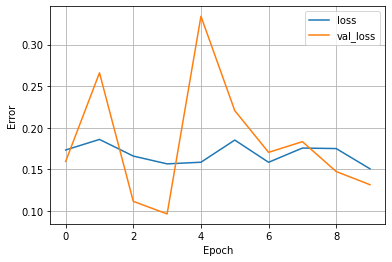

In [142]:


def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

## Teste trainiertes Modell

In [143]:
testdatasize = 10000

(testdata_in, testdata_out) = gen_data(testdatasize)

print(testdata_in.shape)

predictions = mymodel.predict(testdata_in)

somedata = np.random.choice(predictions.shape[0], 5)

for d in somedata:
  print(predictions[d]*180/np.pi, testdata_out[d]*180/np.pi)

error = mymodel.evaluate(testdata_in, testdata_out, verbose=1)
print(np.sqrt(error))

(9444, 2)
[3196.916  2947.7793] [-72.33466503  55.88030846]
[3196.916  2947.7793] [-84.64630635  83.47298536]
[3196.916  2947.7793] [-26.16088368  66.08787288]
[3196.916  2947.7793] [-84.14982315  40.04916389]
[3196.916  2947.7793] [-73.41716136   5.39451899]
296/296 [==============================] - 0s 1ms/step - loss: 0.1137
0.3371712186981889


## Teste verschiedene Trajektorien

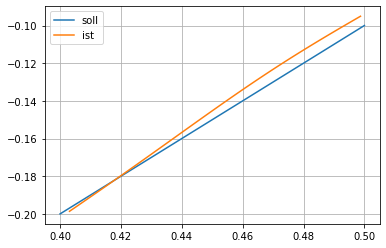

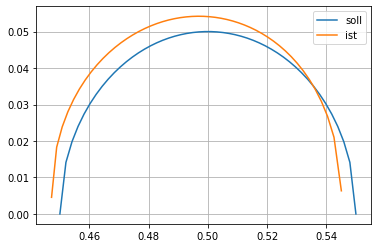

In [109]:
# Gerade

xtest1 = np.linspace(0.4,0.5)
ytest1 = (xtest1-0.4) -0.2

# Parabel
#xtest2 = np.linspace(1, 1.8)
#ytest2 = -0.5*xtest2*xtest2 +2

# Kreisbogen
xtest3 = np.linspace(-0.05, 0.05)
ytest3 = np.sqrt(0.05*0.05 - xtest3*xtest3)
xtest3 = xtest3 + 0.5
ytest3 = ytest3 


def plot_trajectory(x, y):
  plt.figure()
  plt.plot(x,y, label='soll')
  phipred = mymodel.predict(np.vstack((x, y)).T)

  # Berechne x und y
  xpred = l1 * np.cos(phipred[:,0]) + l2 * np.cos(phipred.sum(axis=1))
  ypred = l1 * np.sin(phipred[:,0]) + l2 * np.sin(phipred.sum(axis=1))

  plt.plot(xpred, ypred, label='ist')
  plt.grid(True)
  plt.legend()


plot_trajectory(xtest1, ytest1)

#plot_trajectory(xtest2, ytest2)

plot_trajectory(xtest3, ytest3)

